# Assignment Overview
You’ve been asked to help a clinical data team develop an AI assistant that:	
1. Predicts whether a patient will be readmitted to hospital within 30 days	
2. Extracts and categorises key information from free-text discharge notes.	
This assignment combines a binary classification problem with a lightweight NLP/LLMbased task, both based on the same dataset.	

# 1. Import Libraries

In [47]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from statsmodels.stats.outliers_influence import variance_inflation_factor

# 2. Data Exploration
Perform data cleaning and exploratory analysis	

In [48]:
# read in the provided data
df = pd.read_csv("data/Assignment_Data.csv")
df.shape

(200, 9)

In [9]:
df.head()

,patient_id,age,gender,diagnosis_code,num_previous_admissions,medication_type,length_of_stay,readmitted_30_days,discharge_note
0,1,71,Male,D002,3,Type C,2,0,Good recovery trajectory. Follow-up scan sched...
1,2,34,Female,D002,1,Type B,3,1,Stable post-surgery. Advised to avoid physical...
2,3,80,Male,D002,2,Type C,5,1,Symptoms controlled. Monitoring for relapse ad...
3,4,40,Female,D002,2,Type C,11,0,Stable post-surgery. Advised to avoid physical...
4,5,43,Female,D001,1,Type C,8,1,Stable post-surgery. Advised to avoid physical...


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               200 non-null    int64 
 1   age                      200 non-null    int64 
 2   gender                   200 non-null    object
 3   diagnosis_code           200 non-null    object
 4   num_previous_admissions  200 non-null    int64 
 5   medication_type          200 non-null    object
 6   length_of_stay           200 non-null    int64 
 7   readmitted_30_days       200 non-null    int64 
 8   discharge_note           200 non-null    object
dtypes: int64(5), object(4)
memory usage: 14.2+ KB


__Findings__:
* no missing data
* 200 observations

In [11]:
# Identify feature types

# categorical
cat_feats = df.select_dtypes(include=['object']).columns.to_list()
cat_feats.remove('discharge_note')
print(f'Categorical Features: {cat_feats}')

# numerical - ordinal
num_feats = df.select_dtypes(include=['int64']).columns.to_list()
num_feats.remove('patient_id') # remove id column
num_feats.remove('readmitted_30_days') # remove target variable
print(f'Numerical Features: {num_feats}')

target = 'readmitted_30_days'

Categorical Features: ['gender', 'diagnosis_code', 'medication_type']
Numerical Features: ['age', 'num_previous_admissions', 'length_of_stay']


## 2.1 Categorical Feature Distribution

In [12]:
# Function to add value labels on top of bars
def add_labels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i], f'{y[i]:.1f}%', ha='center', va='bottom')

# Function to plot distribution of a categorical feature
def plot_histogram_categorical(dataset, feature):
    plt.figure(figsize=(8, 5))
    value_counts = dataset[feature].value_counts()
    value_perc = dataset[feature].value_counts(normalize=True)*100
    
    plt.bar(value_counts.index, value_counts.values)

    # Adding value labels
    add_labels(value_counts.index, value_perc.values)

    plt.title(f'Histogram of {feature}')
    plt.xlabel(feat)
    plt.ylabel('Count')
    plt.xticks(rotation=45)    
    plt.tight_layout()
    plt.show()

gender
Female    107
Male       93
Name: count, dtype: int64


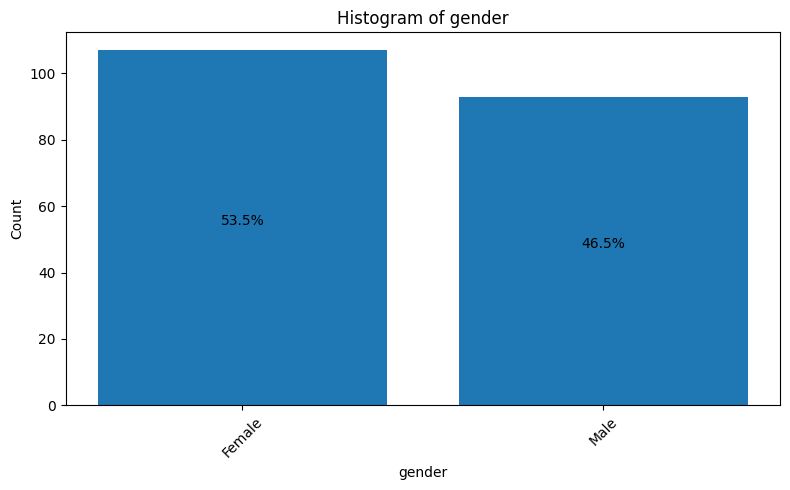

diagnosis_code
D001    56
D002    54
D004    53
D003    37
Name: count, dtype: int64


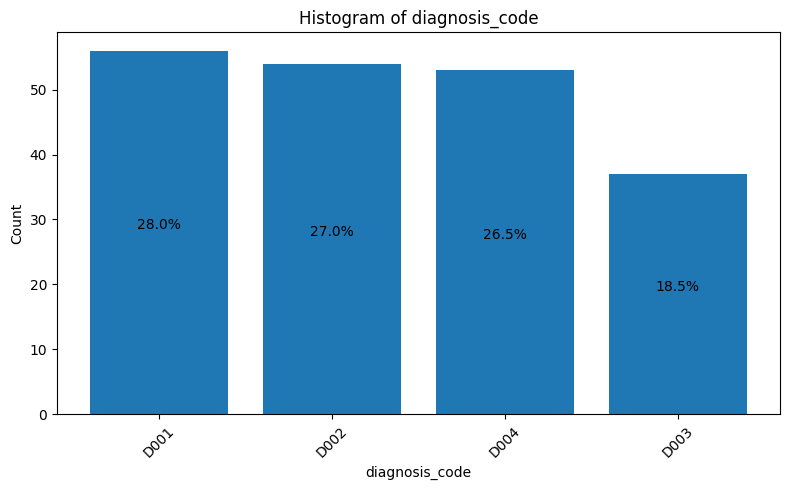

medication_type
Type B    69
Type A    67
Type C    64
Name: count, dtype: int64


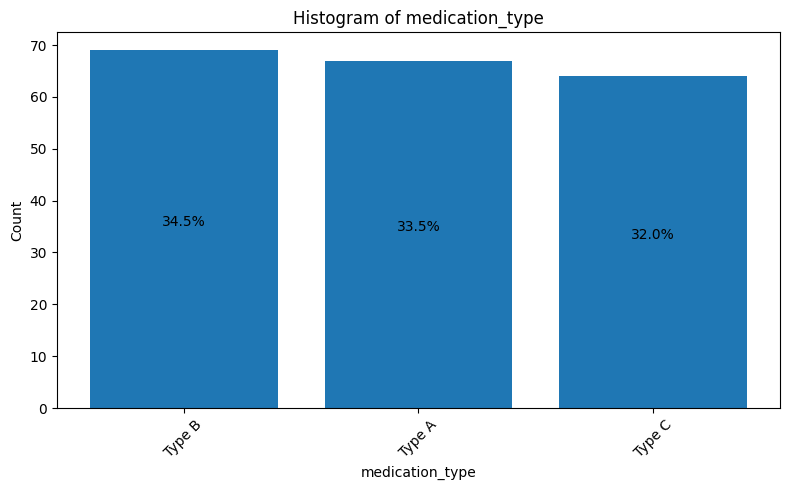

In [13]:
# Plot distribution of categorical features

for feat in cat_feats:
    print(df[feat].value_counts())
    plot_histogram_categorical(df, feat)

__Findings__:
1. __Gender__:The gender distribution is relatively balanced, with a slight skew towards females. The difference (14 more females than males) is small, suggesting a slight overrepresentation of females in this dataset.
2. __Diagnosis Code__: The diagnosis codes are moderately balanced with a slight underrepresentation of D003. D001, D002, and D004 are nearly equal in frequency, suggesting common prevalence or diagnosis of these conditions. D003 stands out with a notably lower count, indicating it may be less common or less commonly diagnosed. 
3. __Medication Type__: This distribution is highly uniform, indicating an almost equal use of all three medication types. 

## 2.2 Numerical Feature Distribution

In [14]:
df[num_feats].describe()

,age,num_previous_admissions,length_of_stay
count,200.000000,200.000000,200.000000
mean,53.720000,1.600000,7.865000
std,21.294574,1.310951,4.134276
min,20.000000,0.000000,1.000000
25%,34.000000,1.000000,4.000000
50%,54.000000,1.000000,8.000000
75%,73.000000,2.000000,11.000000
max,89.000000,6.000000,14.000000


In [15]:
len(df[df['age']>=50]), len(df[df['age']<50])

(114, 86)

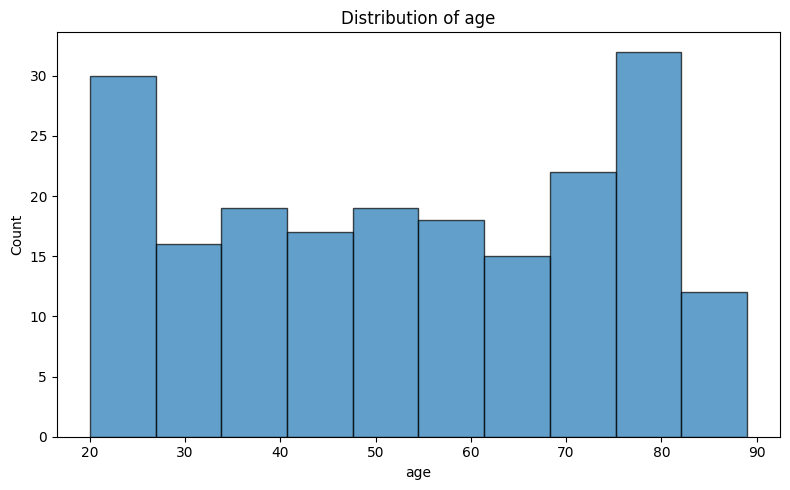

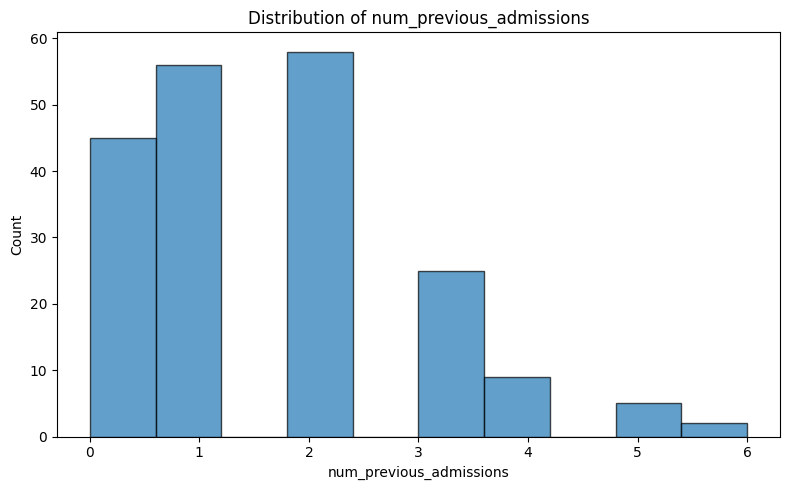

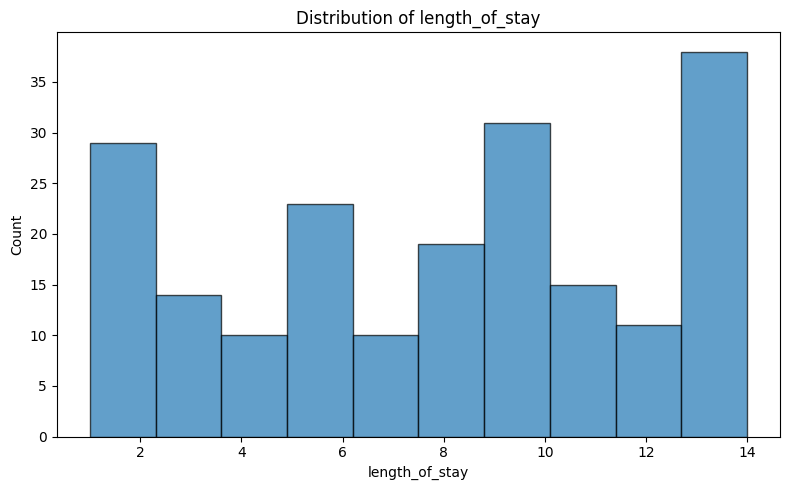

In [16]:
for feat in num_feats:
    plt.figure(figsize=(8, 5))
    plt.hist(df[feat], edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of {feat}')
    plt.xlabel(feat)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

In [17]:
# Calculate skewness and kurtosis for each feature
age_skew = skew(df['age'])
age_kurt = kurtosis(df['age'])  # by default, Fisher’s definition (normal ==> 0)

npa_skew = skew(df['num_previous_admissions'])
npa_kurt = kurtosis(df['num_previous_admissions'])

los_skew = skew(df['length_of_stay'])
los_kurt = kurtosis(df['length_of_stay'])

print(f"Age - Skewness: {age_skew:.3f}, Kurtosis: {age_kurt:.3f}")
print(f"Num Previous Admissions - Skewness: {npa_skew:.3f}, Kurtosis: {npa_kurt:.3f}")
print(f"Length of Stay - Skewness: {los_skew:.3f}, Kurtosis: {los_kurt:.3f}")


Age - Skewness: -0.078, Kurtosis: -1.309
Num Previous Admissions - Skewness: 0.821, Kurtosis: 0.618
Length of Stay - Skewness: -0.125, Kurtosis: -1.244


__Findings__:
1. __Age__: The distribution appears relatively balanced with older and younger patients almost equally represented. There are 86 patients under 50 and 114 patients 50 and above. Apart from being almost symmetrical (very low skewness), it also has a wide spread, covering nearly the full adult lifespan. The flat kurtosis doesn't only indicate a broad distribution but also fewer extreme values than a normal distribution.

2. __Number of Previous Admissions__: A highly right-skewed distribution, with most patients having 0 to 2 prior admissions. This concentration of low values is expected as most people don't have high number of hospital admissions.

3. __Length of Stay__: A fairly balanced distribution centered around 8 days, with peaks in short, medium and long stays. The mild left skew implies a slightly higher frequency of longer stays, but the effect is minimal. Flat kurtosis indicates fewer outliers and a broad spread.

## 2.3 Target Variable Distribution

Text(0.5, 1.0, 'Class Distribution for readmitted_30_days')

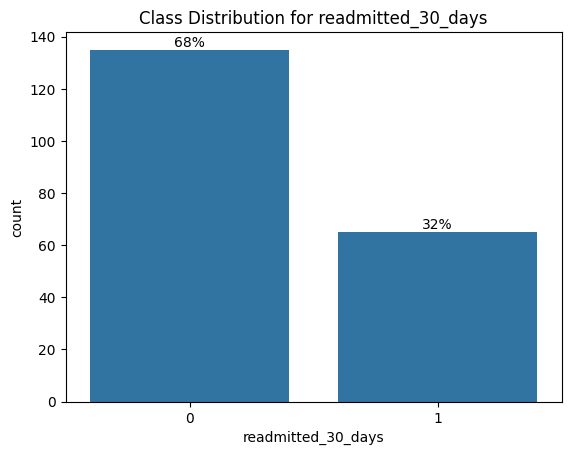

In [18]:
ax = sns.countplot(x=df[target], order=df[target].value_counts(ascending=False).index);
        
value_perc = df[target].value_counts(ascending=False, normalize=True).values * 100
l = [f'{p:.0f}%' for p in value_perc]

ax.bar_label(container=ax.containers[0], labels=l)
plt.title(f'Class Distribution for {target}')

__Findings__:
- The above distribution indicates a moderate class imbalance, where majority of patients were not readmitted within 30 days.

# 3. Feature Engineering
Apply feature engineering: e.g. convert categorical variables to numerical, handle imbalances, derive new features

## 3.1 Derive New Features

In [19]:
# Create age group bins
df['age_group'] = pd.cut(df['age'], bins=[0, 30, 50, 70, 100],
                         labels=['Young', 'Middle-aged', 'Senior', 'Elderly'])

# Define high readmission risk by prior admissions (e.g., >2)
df['high_readmit_risk'] = (df['num_previous_admissions'] > 2).astype(int)

# Combine diagnosis and medication type to capture the effect of medication
df['diag_med_combo'] = df['diagnosis_code'] + "_" + df['medication_type']

# Normalise stay duration relative to prior admissions
# add 1 to prevent zero division
df['stay_per_admission'] = df['length_of_stay'] / (df['num_previous_admissions'] + 1)


In [20]:
# amend cat_feats list
cat_feats=cat_feats+['age_group', 'diag_med_combo']
cat_feats

['gender', 'diagnosis_code', 'medication_type', 'age_group', 'diag_med_combo']

In [21]:
# amend num_feats list
num_feats=num_feats+['high_readmit_risk', 'stay_per_admission']
num_feats

['age',
 'num_previous_admissions',
 'length_of_stay',
 'high_readmit_risk',
 'stay_per_admission']

## 3.2 Categorical Feature Encoding

In [22]:
# Ordinal feature

df_encoded = df.copy()

# map categorical classes to corresponding numerical values

age_group_dict = {'Young':1, 'Middle-aged':2, 'Senior':3, 'Elderly':4} # create dictionary for mapping
df_encoded['age_group']=df_encoded['age_group'].map(age_group_dict) # map to integer values as defined by the dictionary
df_encoded['age_group'].value_counts(dropna=False)

age_group
4    60
3    53
2    47
1    40
Name: count, dtype: int64

In [23]:
# remove age_group_dict from cat_feats and add it to num_feats list
cat_feats.remove('age_group')
num_feats.append('age_group')

In [24]:
# # Non-Ordinal features - Label Encoding
# df_label_enc = df_encoded.copy()

# # Encode non-Ordinal categorical features using label encoding for simplicity

# # Create encoders for each categorical feature except age_group
# label_encoders = {}

# for feat in cat_feats:
#     le = LabelEncoder()
#     df_label_enc[feat] = le.fit_transform(df_label_enc[feat])

In [25]:
# Non-Ordinal features - One-Hot Encoding
df_onehot = df_encoded.copy()

# Encode non-Ordinal categorical features using One-Hot Encoding

# Use pandas get_dummies for one-hot encoding
df_onehot = pd.get_dummies(df_onehot, columns=cat_feats, prefix=cat_feats)

In [27]:
df_onehot.shape
# , df_label_enc.shape

(200, 30)

# 4. Feature Analysis

## 4.1 Multicollinearity Detection

In [28]:
num_feats

['age',
 'num_previous_admissions',
 'length_of_stay',
 'high_readmit_risk',
 'stay_per_admission',
 'age_group']

In [29]:
# Select only the numerical predictors (exclude target, text, or ID columns)
X = df_encoded[num_feats]

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Show features with high multicollinearity (VIF > 5 or 10 is often a red flag)
vif_data.sort_values(by='VIF', ascending=False)

,Feature,VIF
0,age,117.763598
5,age_group,113.691846
2,length_of_stay,14.176999
4,stay_per_admission,9.964380
1,num_previous_admissions,9.699500
3,high_readmit_risk,3.197461


In [30]:
# remove age, length_of_stay, num_previous_admissions
X = df_encoded[['high_readmit_risk','stay_per_admission','age_group']]

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Show features with high multicollinearity (VIF > 5 or 10 is often a red flag)
vif_data.sort_values(by='VIF', ascending=False)

,Feature,VIF
2,age_group,2.799288
1,stay_per_admission,2.393472
0,high_readmit_risk,1.269844


## 4.2 Correlation

In [31]:
# List all column names
all_columns = df_onehot.columns

# Identify one-hot encoded columns (assumes underscores from get_dummies)
onehot_columns = [col for col in all_columns if '_' in col and any(base in col for base in cat_feats)]
onehot_columns

['gender_Female',
 'gender_Male',
 'diagnosis_code_D001',
 'diagnosis_code_D002',
 'diagnosis_code_D003',
 'diagnosis_code_D004',
 'medication_type_Type A',
 'medication_type_Type B',
 'medication_type_Type C',
 'diag_med_combo_D001_Type A',
 'diag_med_combo_D001_Type B',
 'diag_med_combo_D001_Type C',
 'diag_med_combo_D002_Type A',
 'diag_med_combo_D002_Type B',
 'diag_med_combo_D002_Type C',
 'diag_med_combo_D003_Type A',
 'diag_med_combo_D003_Type B',
 'diag_med_combo_D003_Type C',
 'diag_med_combo_D004_Type A',
 'diag_med_combo_D004_Type B',
 'diag_med_combo_D004_Type C']

In [32]:
features = (num_feats + onehot_columns)
features.append(target)
multicol_feats =  ['age', 'length_of_stay', 'num_previous_admissions']
features = np.setdiff1d(features, multicol_feats) #  drop multicollinear features from feature list
features

array(['age_group', 'diag_med_combo_D001_Type A',
       'diag_med_combo_D001_Type B', 'diag_med_combo_D001_Type C',
       'diag_med_combo_D002_Type A', 'diag_med_combo_D002_Type B',
       'diag_med_combo_D002_Type C', 'diag_med_combo_D003_Type A',
       'diag_med_combo_D003_Type B', 'diag_med_combo_D003_Type C',
       'diag_med_combo_D004_Type A', 'diag_med_combo_D004_Type B',
       'diag_med_combo_D004_Type C', 'diagnosis_code_D001',
       'diagnosis_code_D002', 'diagnosis_code_D003',
       'diagnosis_code_D004', 'gender_Female', 'gender_Male',
       'high_readmit_risk', 'medication_type_Type A',
       'medication_type_Type B', 'medication_type_Type C',
       'readmitted_30_days', 'stay_per_admission'], dtype='<U26')

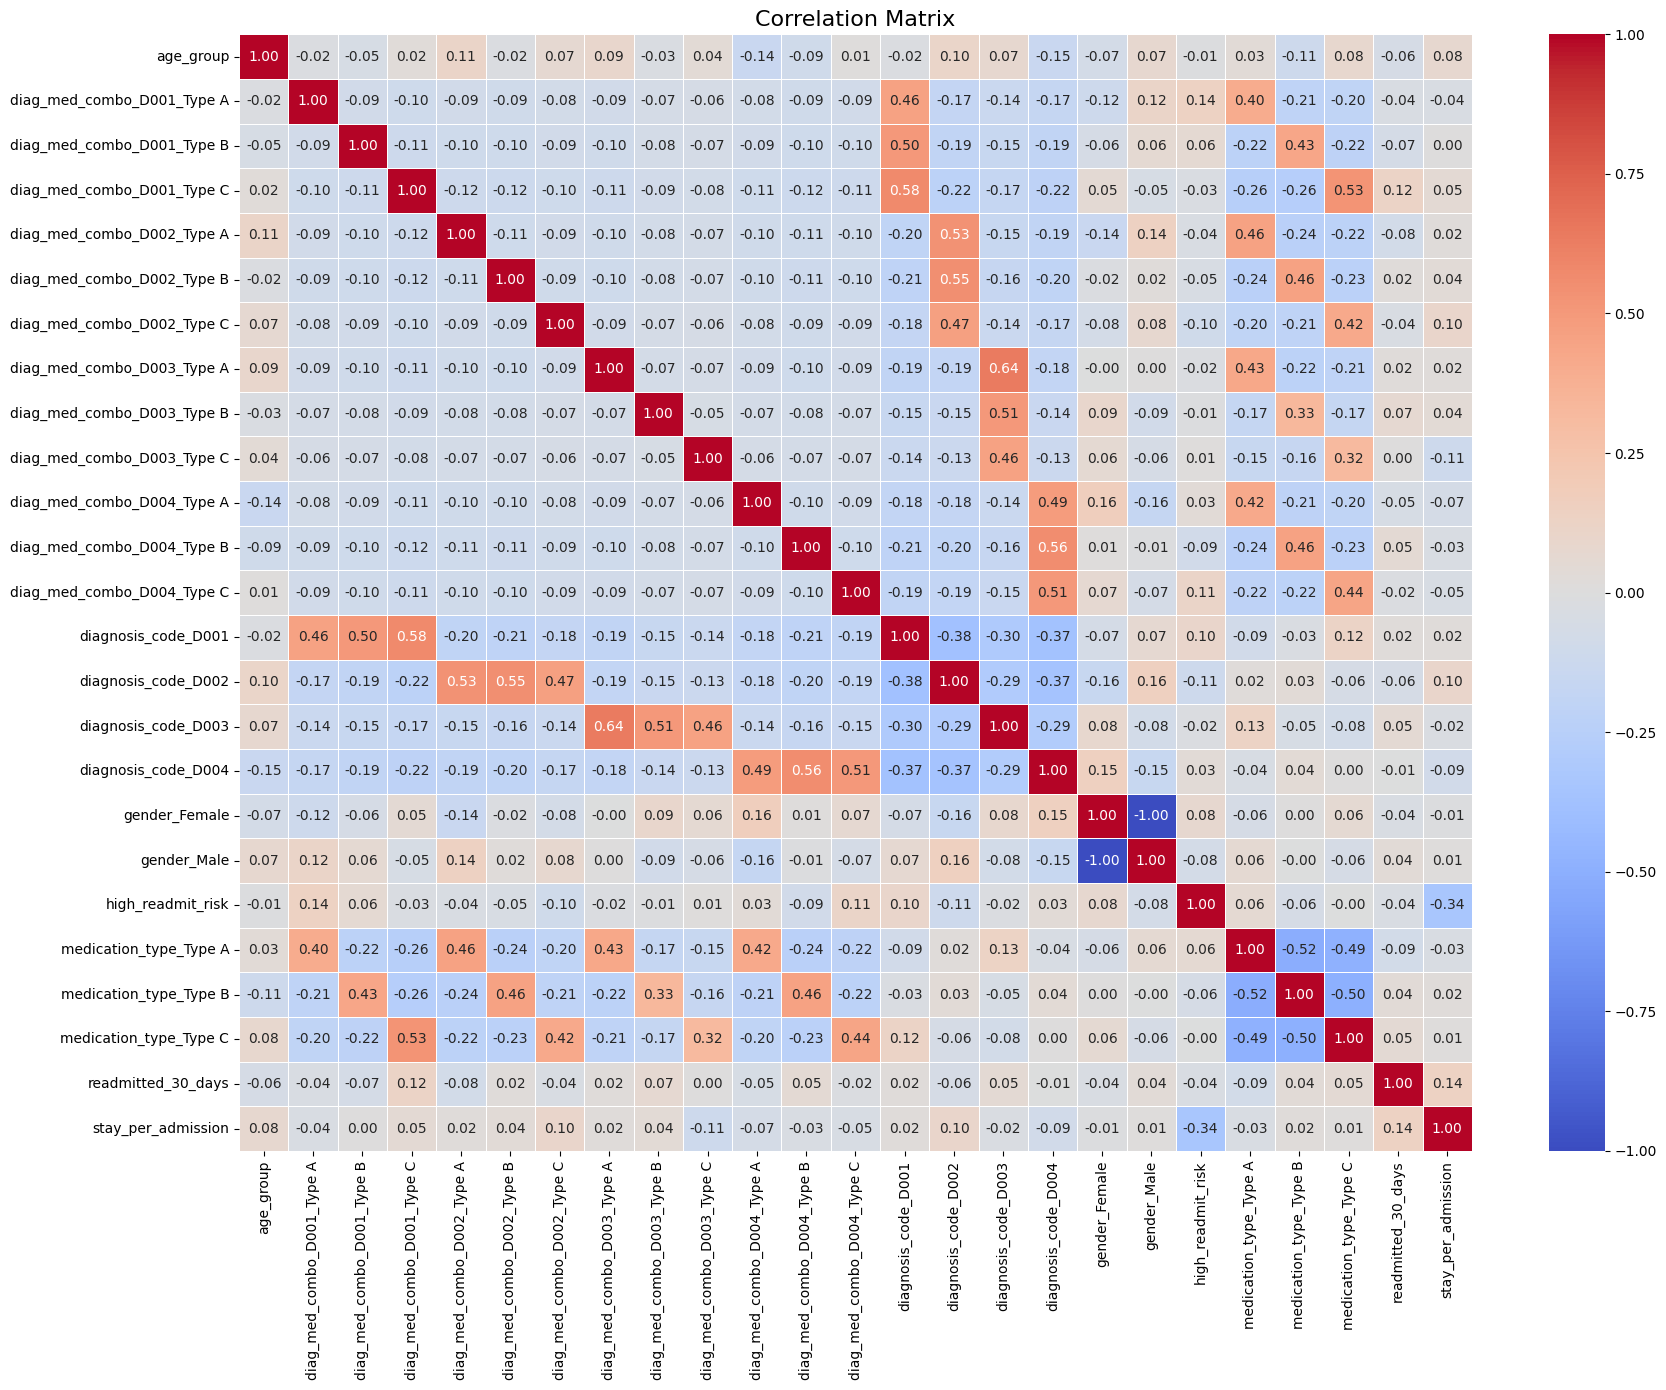

In [33]:
# Plot correlation matrix
corr_matrix = df_onehot[features].corr()

# Set figure size for better readability
plt.figure(figsize=(18, 14))

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [34]:
# list correlation with target variable in descending order from most to least correlated.
corr_matrix[target].abs().sort_values(ascending=False)

readmitted_30_days            1.000000
stay_per_admission            0.135577
diag_med_combo_D001_Type C    0.117955
medication_type_Type A        0.085381
diag_med_combo_D002_Type A    0.079186
diag_med_combo_D001_Type B    0.069009
diag_med_combo_D003_Type B    0.066726
diagnosis_code_D002           0.061316
age_group                     0.060096
diagnosis_code_D003           0.054297
diag_med_combo_D004_Type B    0.053376
medication_type_Type C        0.050347
diag_med_combo_D004_Type A    0.047219
gender_Female                 0.037990
gender_Male                   0.037990
diag_med_combo_D001_Type A    0.035464
diag_med_combo_D002_Type C    0.035464
medication_type_Type B        0.035369
high_readmit_risk             0.035037
diag_med_combo_D004_Type C    0.020096
diagnosis_code_D001           0.019020
diag_med_combo_D003_Type A    0.018182
diag_med_combo_D002_Type B    0.017792
diagnosis_code_D004           0.005442
diag_med_combo_D003_Type C    0.003862
Name: readmitted_30_days,

In [35]:
len(corr_matrix)

25

In [36]:
# select top 5 most correlated features
selected_feats = corr_matrix[target].abs().sort_values(ascending=False).index[1:6].to_list()
selected_feats

['stay_per_admission',
 'diag_med_combo_D001_Type C',
 'medication_type_Type A',
 'diag_med_combo_D002_Type A',
 'diag_med_combo_D001_Type B']

# 5. Handle Class Imbalance - SMOTE

In [37]:
df_onehot['age_group'] = df_onehot['age_group'].astype(int) # force age_group to be integer for SMOTE

## 5.1 Using All Features

In [38]:
features = list(features)
features.remove(target)

# Separate features and target
X = df_onehot[features]
y = df_onehot[target]
seed = 42

# Split before applying SMOTE to prevent data leakage
X_train_all, X_test_all, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_resampled_all, y_train_resampled_all = smote.fit_resample(X_train_all, y_train)

print("Original training set class distribution:\n", y_train.value_counts())
print("Resampled training set class distribution:\n", y_train_resampled_all.value_counts())

C:\Users\haerb\anaconda3\envs\ner-env\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Original training set class distribution:
 readmitted_30_days
0    108
1     52
Name: count, dtype: int64
Resampled training set class distribution:
 readmitted_30_days
0    108
1    108
Name: count, dtype: int64


## 5.2 Using Selected Features

In [39]:
# Separate features and target
X = df_onehot[selected_feats]
y = df_onehot[target]
seed = 42

# Split before applying SMOTE to prevent data leakage
X_train_selected, X_test_selected, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_resampled_selected, y_train_resampled_selected = smote.fit_resample(X_train_selected, y_train)

print("Original training set class distribution:\n", y_train.value_counts())
print("Resampled training set class distribution:\n", y_train_resampled_selected.value_counts())

Original training set class distribution:
 readmitted_30_days
0    108
1     52
Name: count, dtype: int64
Resampled training set class distribution:
 readmitted_30_days
0    108
1    108
Name: count, dtype: int64


C:\Users\haerb\anaconda3\envs\ner-env\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [40]:
X_train_resampled.columns.to_list()

NameError: name 'X_train_resampled' is not defined

In [41]:
X_train_resampled_selected.columns.to_list()

['stay_per_admission',
 'diag_med_combo_D001_Type C',
 'medication_type_Type A',
 'diag_med_combo_D002_Type A',
 'diag_med_combo_D001_Type B']

# 6. Model Development
- Train a classification model (e.g. logistic regression, random forest, XGBoost)	
- Evaluate using ROC AUC, F1-score, and confusion matrix	
- Explain which features were most influential

In [42]:
def model_train_predict_evaluate(model, X_train, y_train, X_test, y_test):
    
    #train predictive model
    model.fit(X_train, y_train)
    
    # Make Predictions on Training and Test Sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Evaluate the Model
    print("Training Set Evaluation:")
    print(classification_report(y_train, y_train_pred))
    print("Training Set Accuracy:", accuracy_score(y_train, y_train_pred))
    
    print("\nTest Set Evaluation:")
    print(classification_report(y_test, y_test_pred))
    print("Test Set Accuracy:", accuracy_score(y_test, y_test_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))

## 6.1 Base Model (All Features)

In [43]:
# create RandomForestClassifier instance
base_model = RandomForestClassifier(random_state=seed)

# train, predict & evaluate model
model_train_predict_evaluate(base_model, X_train_resampled_all, y_train_resampled_all, X_test_all, y_test)

Training Set Evaluation:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       108
           1       0.99      1.00      1.00       108

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216

Training Set Accuracy: 0.9953703703703703

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.63      0.70      0.67        27
           1       0.20      0.15      0.17        13

    accuracy                           0.53        40
   macro avg       0.42      0.43      0.42        40
weighted avg       0.49      0.53      0.51        40

Test Set Accuracy: 0.525
ROC AUC: 0.3247863247863248


__Findings__:
- The base model performs much worse on the test set than the training set which indicates significant overfitting.
- The performance on the test set shows the model is biased towards the negative class where both precision (ability to predict a class) and recall (ability to identify a class) are much higher than the positive class.
- At 52.5 % the accuracy on the test set is slightly better than random guessing.
- ROC AUC of 0.32 means that the model is worse than random at ranking predictions.

## 6.2 Challenger Model (Selected Features)

In [44]:
# create RandomForestClassifier instance
challenger_model = RandomForestClassifier(random_state=seed)

# train, predict & evaluate model
model_train_predict_evaluate(base_model, X_train_resampled_selected, y_train_resampled_selected, X_test_selected, y_test)

Training Set Evaluation:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       108
           1       0.89      0.84      0.87       108

    accuracy                           0.87       216
   macro avg       0.87      0.87      0.87       216
weighted avg       0.87      0.87      0.87       216

Training Set Accuracy: 0.8703703703703703

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.70      0.78      0.74        27
           1       0.40      0.31      0.35        13

    accuracy                           0.62        40
   macro avg       0.55      0.54      0.54        40
weighted avg       0.60      0.62      0.61        40

Test Set Accuracy: 0.625
ROC AUC: 0.5498575498575499


__Findings__:
- The difference in performance between the train & test set is much less compared to the base model which means the model generalises better.
- However, the model is still biased towards the negative class even though the difference in precision, recall & f-1 score have slightly improved.
- The accuracy on the test set (62.5%) & the ROC AUC (0.55) have clearly improved suggesting that the model is better than random guessing.

__Explanation__:
- Overfitting could be due to
    - Applying SMOTE on a small dataset.
    - Some features may be irrelevant or introduce noise, especially one-hot encoded ones with few occurrences.
- The likely reasons the model is biased are
    - The original class distribution is imbalanced.
    - Even after SMOTE, the model still sees the minority class as rare/noisy.
    - SMOTE created synthetic positives that don’t match the real test data well.
  
__Steps to Improve Generalisation__:
- Reducing number of features by prioritising features based on correlations seems to have improved performance. Get optimal feature count by plotting performance vs. number of features. 
- Tune model complexity by optimising max_depth, min_samples_leaf in Random Forest.
- Try cross-validation with StratifiedKFold to get more robust performance estimates.
- Try other models such as Logistic Regression or XGBoost with regularization.

__Steps to Address Bias__:
- Try class weighting in the model (class_weight: 'balanced').
- Use precision-recall curves to explore thresholds that balance sensitivity to the positive class.

# 7. Feature Importance

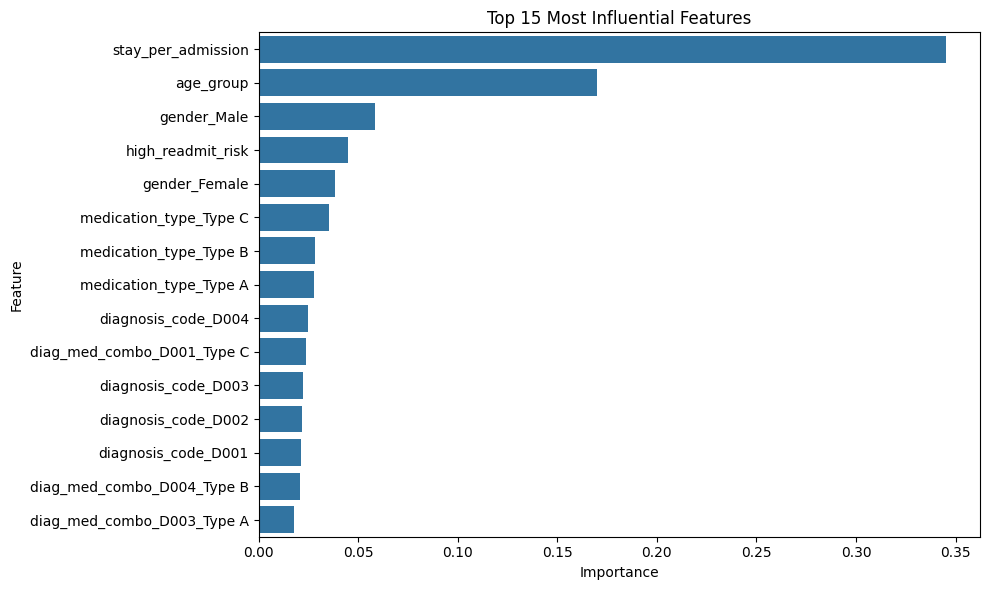

In [45]:
# Extract feature importances

X = df_onehot[features]
y = df_onehot[target]

base_model.fit(X_train_resampled_all, y_train_resampled_all)
feature_importances = pd.Series(base_model.feature_importances_, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(15)

# Plot top 15 features
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 15 Most Influential Features")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [46]:
top_features

stay_per_admission            0.345038
age_group                     0.169881
gender_Male                   0.058512
high_readmit_risk             0.044634
gender_Female                 0.038429
medication_type_Type C        0.035203
medication_type_Type B        0.028435
medication_type_Type A        0.027839
diagnosis_code_D004           0.024834
diag_med_combo_D001_Type C    0.023655
diagnosis_code_D003           0.022195
diagnosis_code_D002           0.021967
diagnosis_code_D001           0.021391
diag_med_combo_D004_Type B    0.020630
diag_med_combo_D003_Type A    0.017913
dtype: float64

__Findings__:
The following are top 5 most influential features starting from the highest feature importance
- __stay_per_admission__ (0.345038) is by far the most predictive feature. This suggests that the longer a patient stays in the hospital relative to prior admissions, the higher their risk of readmission. Captures patient complexity and care burden.
- __age_group__ (0.170)  - Older patients are likely to have higher readmission risks.
- __gender_Male__ (0.059) - The model finds "male" moderately informative.
- __high_readmit_risk__ (0.045) - This suggests prior admissions are moderately predictive as we expect high readmission risk for chronically ill patients.
- __gender_Female__ (0.038) - Female gender is slightly less predictive than male suggesting a gender imbalance in risk factors or behaviours.	